In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
cd /content/drive/MyDrive/landcover_miniproject3

/content/drive/MyDrive/landcover_miniproject3


In [13]:
pip install rasterio

In [4]:
import numpy as np #untuk melakukan hitungan rumus spt sum dll
import matplotlib.pyplot as plt #untuk bisa membuat chart
from tensorflow.keras.preprocessing.image import img_to_array #untuk mengubah image ke array(grafik/tabel)
from tensorflow.keras.models import load_model #untuk bisa load model
import rasterio #untuk mengekstrak atau memberikan sistem koordinat pada data gambar
from PIL import Image #untuk import TIF atau data gambar
from rasterio.features import shapes
import geopandas as gpd #untuk mengeksport shapefile, dan edit atribut data
from shapely.geometry import shape

In [5]:
# Mapping warna ke kelas (untuk visualisasi)
COLOR_MAP = {
    (96, 230, 99): 0,  # hutan_lahan_kering_primer
    (114, 255, 0): 1,  # hutan_lahan_kering_sekunder
    (229, 210, 152): 2,  # perkebunan
    (235, 192, 167): 3,  # semak_belukar
    (211, 229, 152): 4,  # hutan_tanaman
    (0, 0, 0): 5,  # pemukiman
    (214, 0, 115): 6,  # tanah_terbuka
    (212, 252, 247): 7,  # tubuh_air
    (255, 127, 127): 8,  # semak_belukar_rawa
    (246, 254, 167): 9,  # pertanian_lahan_kering
    (237, 245, 0): 10,  # pertanian_lahan_kering_campursemak
    (168, 214, 255): 11,  # sawah
    (202, 122, 245): 12,  # bandara/pelabuhan
    (114, 142, 167): 13,  # transmigrasi
    (167, 4, 0): 14  # pertambangan
}


In [7]:
# Mapping kelas ke nama label (untuk atribut Shapefile)
CLASS_LABELS = {
    0: "hutan_lahan_kering_primer",
    1: "hutan_lahan_kering_sekunder",
    2: "perkebunan",
    3: "semak_belukar",
    4: "hutan_tanaman",
    5: "pemukiman",
    6: "tanah_terbuka",
    7: "tubuh_air",
    8: "semak_belukar_rawa",
    9: "perkebunan_lahan_kering",
    10: "perkebunan_lahan_kering_campursemak",
    11: "sawah",
    12: "bandara/pelabuhan",
    13: "transmigrasi",
    14: "pertambangan"
}


Ukuran gambar (PIL): (4669, 4719)
Dimensi gambar (PIL): (4719, 4669, 3)
Dimensi gambar asli (RGB, rasterio): 4719x4669x3


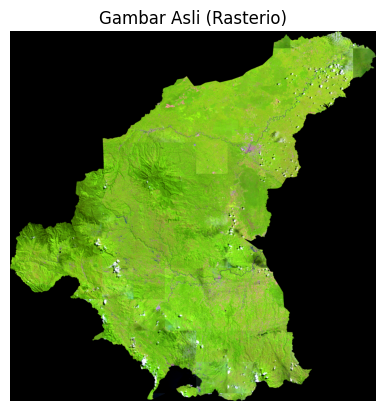

In [14]:

# Fungsi untuk mengonversi kelas ke warna (untuk visualisasi)
def class_to_color(class_mask, color_map):
    color_image = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
    for color, class_id in color_map.items():
        color_image[class_mask == class_id] = color
    return color_image

# Path input dan output
image_path = '/content/drive/MyDrive/landcover_miniproject3/dataset/image/tif1.tif'
output_shp_path = '/content/drive/MyDrive/landcover_miniproject3/dataset/image/result.shp'

# Verifikasi gambar dengan PIL (opsional)
img_pil = Image.open(image_path)
print("Ukuran gambar (PIL):", img_pil.size)  # (lebar, tinggi)
img_array_pil = np.array(img_pil)
print("Dimensi gambar (PIL):", img_array_pil.shape)  # (tinggi, lebar, channels)

# Langkah 1: Load gambar asli tanpa resize dengan rasterio
with rasterio.open(image_path) as src:
    img_array = src.read()  # Baca semua band
    img_array = img_array.transpose(1, 2, 0)  # Ubah ke (height, width, channels)
    transform = src.transform  # Simpan transform untuk georeferensi
    crs = src.crs  # Simpan CRS untuk Shapefile

# Ambil hanya 3 band pertama (RGB) dan normalisasi
img_array_rgb = img_array[:, :, :3] / 255.0  # Ambil band 0, 1, 2 (RGB)
height, width = img_array_rgb.shape[0], img_array_rgb.shape[1]
print(f"Dimensi gambar asli (RGB, rasterio): {height}x{width}x3")

# Tampilkan gambar asli untuk verifikasi
img = Image.fromarray((img_array_rgb * 255).astype(np.uint8))
plt.imshow(img)
plt.title("Gambar Asli (Rasterio)")
plt.axis('off')
plt.show()


In [25]:
# Load model (ganti path model sesuai lokasi Anda)
model_loaded = load_model('/content/drive/MyDrive/landcover_miniproject3/model/unet/model_best_unet_100.h5')  # Sesuaikan path , anda juga bisa memilih menggunakan model Unet maupun DeepLabV3+


In [26]:

# Ukuran tile yang diharapkan model
tile_size = 256
# Inisialisasi array untuk menyimpan hasil prediksi dengan ukuran asli
pred_classes_full = np.zeros((height, width), dtype=np.uint8)


In [27]:

# Langkah 2: Proses gambar dalam tiles
for y in range(0, height, tile_size):
    for x in range(0, width, tile_size):
        # Tentukan batas tile
        y_end = min(y + tile_size, height)
        x_end = min(x + tile_size, width)
        tile_height = y_end - y
        tile_width = x_end - x

        # Ambil tile dari gambar asli (RGB)
        tile = img_array_rgb[y:y_end, x:x_end, :]

        # Jika tile lebih kecil dari 256x256, pad dengan nol
        if tile_height < tile_size or tile_width < tile_size:
            tile_padded = np.zeros((tile_size, tile_size, 3), dtype=np.float32)
            tile_padded[:tile_height, :tile_width, :] = tile
        else:
            tile_padded = tile

        # Tambahkan dimensi batch
        tile_input = np.expand_dims(tile_padded, axis=0)  # (1, 256, 256, 3)

        # Prediksi untuk tile
        pred_tile = model_loaded.predict(tile_input, verbose=0)
        pred_classes_tile = np.argmax(pred_tile, axis=-1)[0]  # (256, 256)

        # Potong hasil prediksi sesuai ukuran tile asli
        pred_classes_full[y:y_end, x:x_end] = pred_classes_tile[:tile_height, :tile_width]



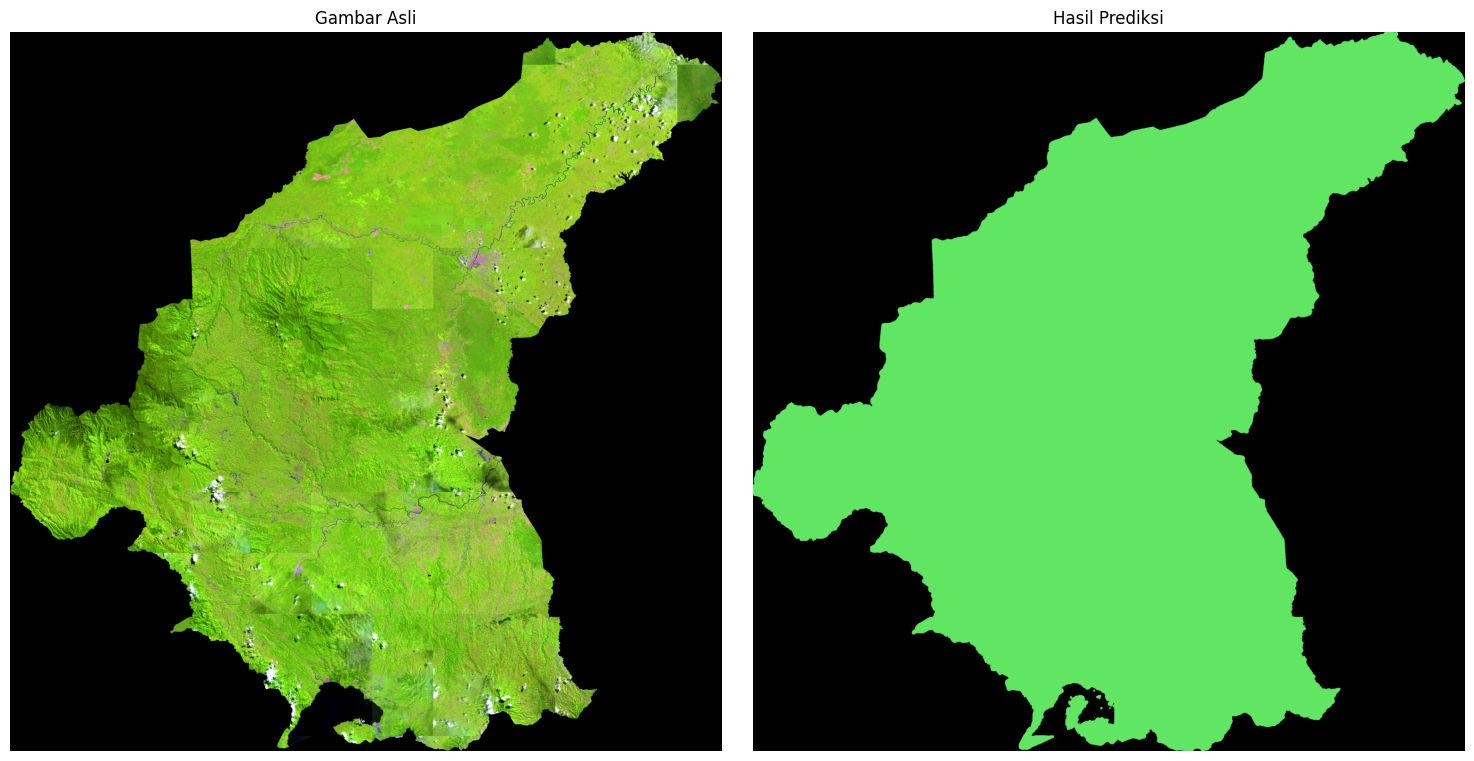

In [29]:
# Langkah 3: Visualisasi hasil prediksi
pred_colored = class_to_color(pred_classes_full, COLOR_MAP)
plt.figure(figsize=(15, 7.5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Gambar Asli")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(pred_colored)
plt.title("Hasil Prediksi")
plt.axis("off")
plt.tight_layout()
plt.show()



In [30]:
# Langkah 4: Konversi raster ke poligon
shapes_gen = shapes(pred_classes_full, transform=transform)

# Buat list untuk menyimpan geometri dan atribut
geometries = []
labels = []

for geom, value in shapes_gen:
    geometries.append(shape(geom))  # Konversi ke shapely geometry
    labels.append(CLASS_LABELS[int(value)])  # Ambil nama label dari kelas

# Buat GeoDataFrame awal
gdf = gpd.GeoDataFrame({
    'geometry': geometries,
    'label_name': labels
})



In [31]:
# Langkah 5: Gabungkan poligon berdasarkan label_name
gdf_dissolved = gdf.dissolve(by='label_name', aggfunc='first').reset_index()

# Set CRS dari file asli
gdf_dissolved.crs = crs




In [32]:
# Simpan ke Shapefile
gdf_dissolved.to_file(output_shp_path)
print(f"Hasil prediksi kelas disimpan sebagai Shapefile di: {output_shp_path}")
print(f"Jumlah kategori unik di Shapefile: {len(gdf_dissolved)}")


Hasil prediksi kelas disimpan sebagai Shapefile di: /content/drive/MyDrive/landcover_miniproject3/dataset/image/result.shp
Jumlah kategori unik di Shapefile: 2
